In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

import arviz as az

In [2]:
az.style.use('arviz-white')

# Gibbs sampling for simple linear regression


For observation $i=1, \dots,n$
, let $Y_i$ be the response and $X_i$ be the covariate. The model is $Y_i\sim\mbox{Normal}(\alpha + \beta X_i,\sigma^2)$.

We select priors:
* $\alpha,\beta \sim\mbox{Normal}(\mu_0,\sigma_0^2)$ 
* $\sigma^2\sim\mbox{InvGamma}(a,b)$.

To illustrate the method we regress the log odds of a baby being named “Sophia'' (Y) onto the year (X). To improve convergence we take $X$ to be the year - 1984 (so that $X$ is centered on zero).

In [3]:
dat = pd.read_csv('data/babynames.csv')
dat = dat.query('name=="Sophia" and sex=="F" and year>1950')
dat.head()

,year,sex,name,n,prop
472952,1951,F,Sophia,153,0.000083
483588,1952,F,Sophia,110,0.000058
494161,1953,F,Sophia,130,0.000067
505103,1954,F,Sophia,112,0.000056
515940,1955,F,Sophia,152,0.000076


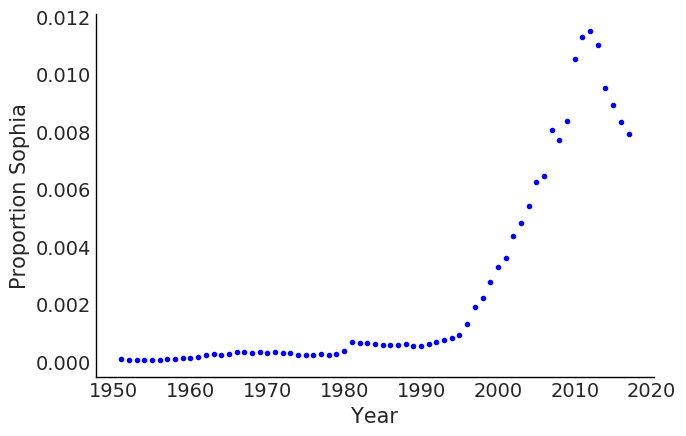

In [4]:
yr  = dat.year
p   = dat.prop

X   = dat.year - 1984
Y   = np.log(p/(1-p))
n   = len(X)

plt.plot(yr, p, 'b.');
plt.xlabel("Year")
plt.ylabel("Proportion Sophia");

In [5]:
results = smf.ols('Y~X', dat).fit()

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     848.2
Date:                Thu, 25 Apr 2019   Prob (F-statistic):           5.13e-39
Time:                        15:13:10   Log-Likelihood:                -37.748
No. Observations:                  67   AIC:                             79.50
Df Residuals:                      65   BIC:                             83.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.1885      0.053   -136.347      0.000      -7.294      -7.083
X              0.0794      0.003     29.125      0.000       0.074       0.085
==============================================================================
Omnibus:                       14.668   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.634
Skew:                          -0.315   Prob(JB):                       0.0986
Kurtosis:                       1.876   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
results.params

Intercept   -7.188465
X            0.079399
dtype: float64

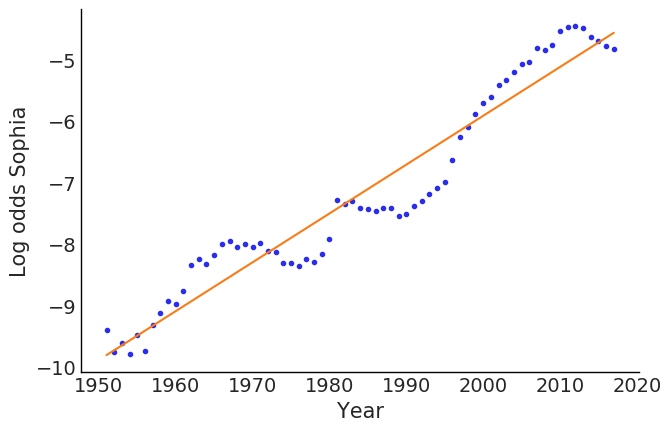

In [8]:
plt.plot(yr, Y, '.')
y_hat = results.params[0] + results.params[1] * X
plt.plot(yr, y_hat, 'C1')
plt.xlabel("Year")
plt.ylabel("Log odds Sophia");

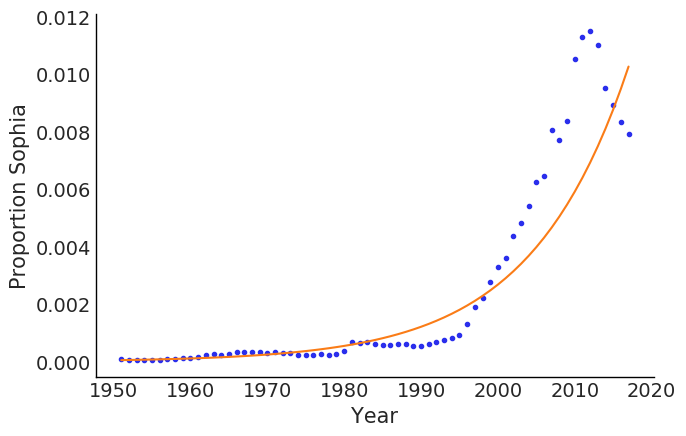

In [9]:
# Plot fitted values on the proportion scale
plt.plot(yr, p, '.')
p_hat = np.exp(y_hat) / (1 + np.exp(y_hat))
plt.plot(yr, p_hat, 'C1')
plt.xlabel("Year")
plt.ylabel("Proportion Sophia");

# MCMC!

In [10]:
# Priors

mu_0 = 0
s2_0 = 1000
a = 0.01
b = 0.01

In [11]:
n_iters = 3000

# Initial values
α = results.params[0]
β = results.params[1]
s2 = results.resid.var()

α_list = []
β_list = []
s2_list = []

for iter in range(2, n_iters):
    # sample alpha
    V = n/s2+mu_0/s2_0
    M = np.sum(Y-X*β)/s2+1/s2_0
    α = stats.norm(M/V, 1/V**0.5).rvs(1)[0]

    # sample beta
    V = np.sum(X ** 2)/s2+mu_0/s2_0
    M = np.sum(X*(Y-α))/s2+1/s2_0
    β = stats.norm(M/V, 1/V**0.5).rvs(1)[0]

    # sample s2|mu,Y,Z
    A = n/2 + a
    B = np.sum((Y-α-X*β) ** 2)/2 + b
    s2 = stats.invgamma(A, scale=B).rvs(1)[0]

    # keep track of the results
    α_list.append(α)
    β_list.append(β)
    s2_list.append(s2)

keepers = {'α': α_list, 'β': β_list, 's2': s2_list}

## Plots of the joint posterior distribution

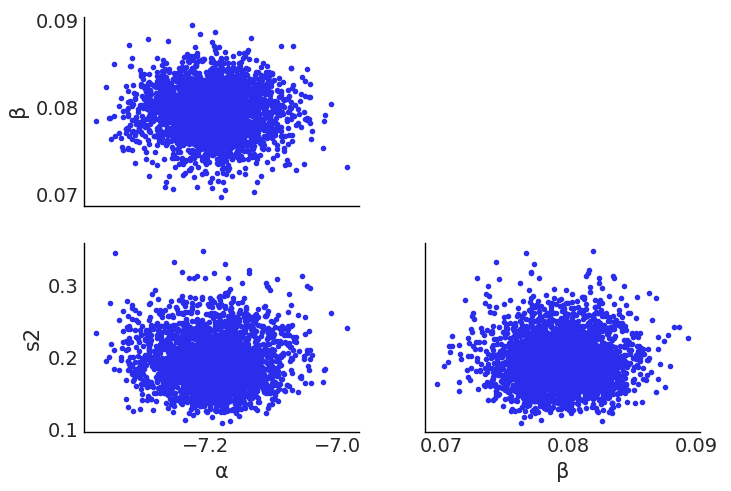

In [12]:
az.plot_pair(keepers);

## Summarize the marginal distributions in a table

In [13]:
summary = az.summary(keepers)
summary

,mean,sd,mc error,hpd 3%,hpd 97%
α,-7.19,0.05,0.0,-7.29,-7.09
β,0.08,0.00,0.0,0.07,0.08
s2,0.19,0.03,0.0,0.14,0.26


## Plot the marginal posterior $f(\beta  \mid Y)$

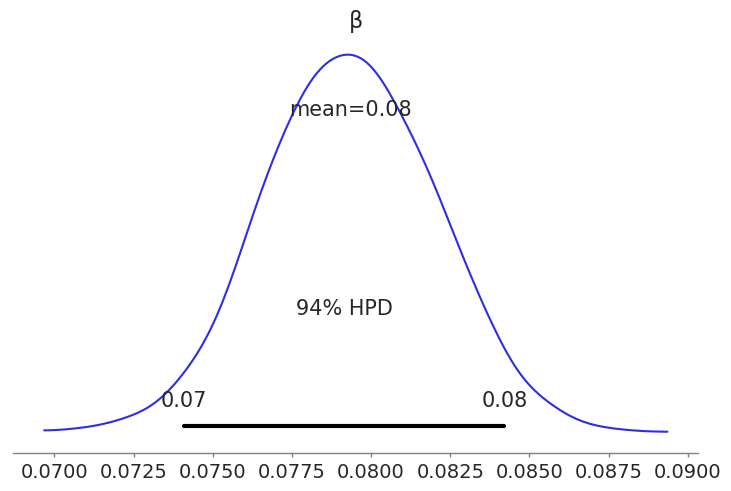

In [14]:
az.plot_posterior(keepers, var_names=['β'], round_to=2);

## Plot the fitted regression line

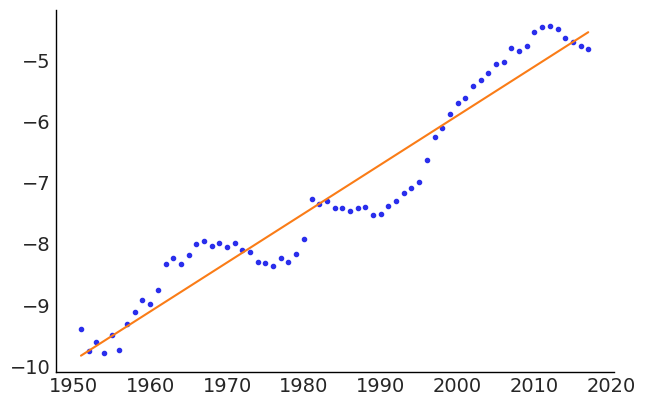

In [15]:
plt.plot(yr, Y, '.')
plt.plot(yr, summary['mean']['α'] + summary['mean']['β'] * X, 'C1');